# Importing Necessary Python Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os as os
import numpy as np
import pandas as pd

In [2]:
import opendatasets as od

In [3]:
data='https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'

# Function for getting data from given directory

In [4]:
labels = ['PNEUMONIA','NORMAL']
img_size = 150
def get_data(data_dir):
    data =[]
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try :
                img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr,(img_size,img_size)) #Reshaping Images to preferred Size
                data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
os.getcwd()

'C:\\Users\\bhavye\\Downloads'

# Description of the Pneumonia Dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 


In [6]:
train = get_data('C:/Users/bhavye/Downloads/chest-xray-pneumonia/chest_xray/train')
test = get_data('C:/Users/bhavye/Downloads/chest-xray-pneumonia/chest_xray/test')
val = get_data('C:/Users/bhavye/Downloads/chest-xray-pneumonia/chest_xray/val')

C:\Users\bhavye\AppData\Local\Temp/ipykernel_20984/2475740348.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Data Visualization & Preprocessing

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train :
    x_train.append(feature)
    y_train.append(label)
for feature, label in test :
    x_test.append(feature)
    y_test.append(label)
for feature, label in val :
    x_val.append(feature)
    y_val.append(label)

In [8]:
positives = []
negatives =[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else : 
        negatives.append(x_train[i])

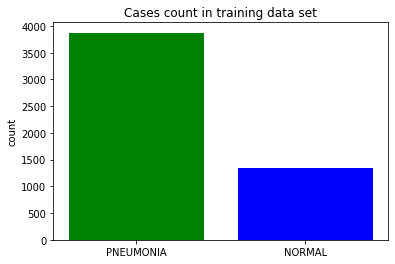

In [9]:
plt.bar(labels,[len(negatives),len(positives)],color=["green","blue"])
plt.title("Cases count in training data set")
plt.ylabel("count")
plt.show()

The data is unbalanced . To increase the no. of training examples, we will use data augmentation

# Previewing the images of both the classes

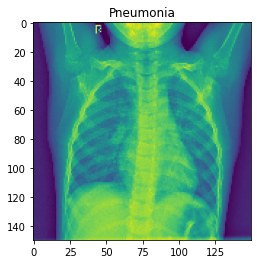

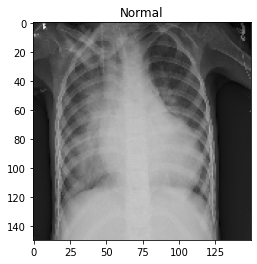

In [10]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4],cmap="gray")
plt.title("Normal")
plt.show()

# Normalize the data

Performed a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [11]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [12]:
# resize data for deep learning 
x_train = x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1,img_size,img_size,1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1,img_size,img_size,1)
y_test = np.array(y_test)

In [13]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

# Data Augmentation

It is used to prevent overfitting and handling the imbalance in dataset. It can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Some popular augmentations are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

In [14]:

datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset 
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.2, # Randomly zoom image 
        width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range =0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True, # randomly flip images
        vertical_flip=False # randomly flip images
)

datagen.fit(x_train)

# Training the Model 

In [15]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='same',activation='relu',input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))

model.add(Conv2D(64,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))

model.add(Conv2D(64,(3,3),strides=1,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))

model.add(Conv2D(128,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))

model.add(Conv2D(256,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))

model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer="rmsprop",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [16]:
model.compile(optimizer="rmsprop", loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                           patience = 2,
                                           verbose = 1,
                                           factor = 0.3,
                                           min_lr = 0.000001)

In [18]:
training = model.fit(datagen.flow(x_train,y_train,batch_size=32),epochs=10,validation_data=datagen.flow(x_val,y_val),callbacks = learning_rate_reduction)

Epoch 1/10
163/163 [==============================] - 257s 2s/step - loss: 0.5585 - accuracy: 0.8499 - val_loss: 24.7565 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 216s 1s/step - loss: 0.2687 - accuracy: 0.9078 - val_loss: 29.7611 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9189
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 216s 1s/step - loss: 0.2242 - accuracy: 0.9189 - val_loss: 56.2917 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 211s 1s/step - loss: 0.1456 - accuracy: 0.9461 - val_loss: 7.6802 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 196s 1s/step - loss: 0.1399 - accuracy: 0.9505 - val_loss: 1.6746 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/10
163/163 [============================

In [19]:
# model.save_weights('kaggle/saved_model_ai/pneumoniadetection')

In [20]:
print("Loss of the model is -", model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is -", model.evaluate(x_test,y_test)[1]*100,"%")

20/20 [==============================] - 5s 242ms/step - loss: 0.2973 - accuracy: 0.8862
Loss of the model is - 0.2972606420516968
20/20 [==============================] - 5s 234ms/step - loss: 0.2973 - accuracy: 0.8862
Accuracy of the model is - 88.62179517745972 %


# Analysis after Model Training

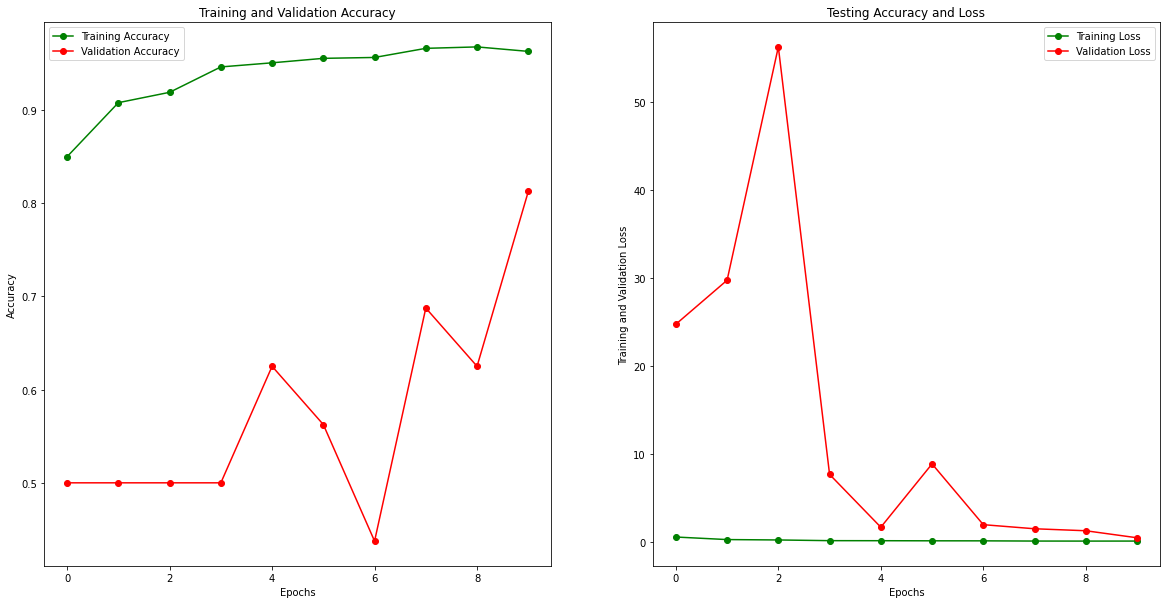

In [26]:
epochs = list(range(10))
fig , ax = plt.subplots(1,2)
train_acc = training.history['accuracy']
train_loss = training.history['loss']
val_acc = training.history['val_accuracy']
val_loss = training.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs,train_acc,'go-',label = 'Training Accuracy')
ax[0].plot(epochs,val_acc,'ro-',label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs,train_loss,'g-o',label='Training Loss')
ax[1].plot(epochs, val_loss,'r-o',label='Validation Loss')
ax[1].set_title('Testing Accuracy and Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training and Validation Loss")
plt.show()

In [27]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 5s 246ms/step


In [28]:
print(classification_report(y_test,predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.87      0.91       390
   Normal (Class 1)       0.81      0.91      0.86       234

           accuracy                           0.89       624
          macro avg       0.88      0.89      0.88       624
       weighted avg       0.89      0.89      0.89       624



In [29]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm,index = ['0','1'], columns = ['0','1'])
cm

,0,1
0,339,51
1,20,214


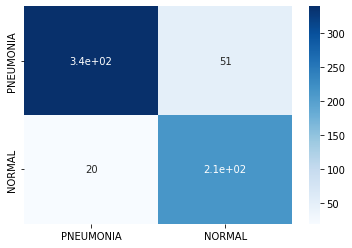

In [30]:
sns.heatmap(cm,cmap="Blues",annot=True, xticklabels = labels,yticklabels=labels)
plt.show()

In [56]:
def pneumoniaPrediction(img):
    img = np.array(img)/255
    img = img.reshape(-1,150,150,1)
    isPneumonic = model.predict(img)[0]
    imgClass = 'Pneumonia' if isPneumonic<0.5 else "Normal"
    return imgClass

In [57]:
pr = model.predict(x_test)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=1
    else : 
        pr[i]=0

20/20 [==============================] - 4s 206ms/step


In [58]:
import IPython
from IPython.display import display

In [59]:
def prepare(filepath):
    IMG_SIZE=150
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

1/1 [==============================] - 0s 37ms/step
Normal 



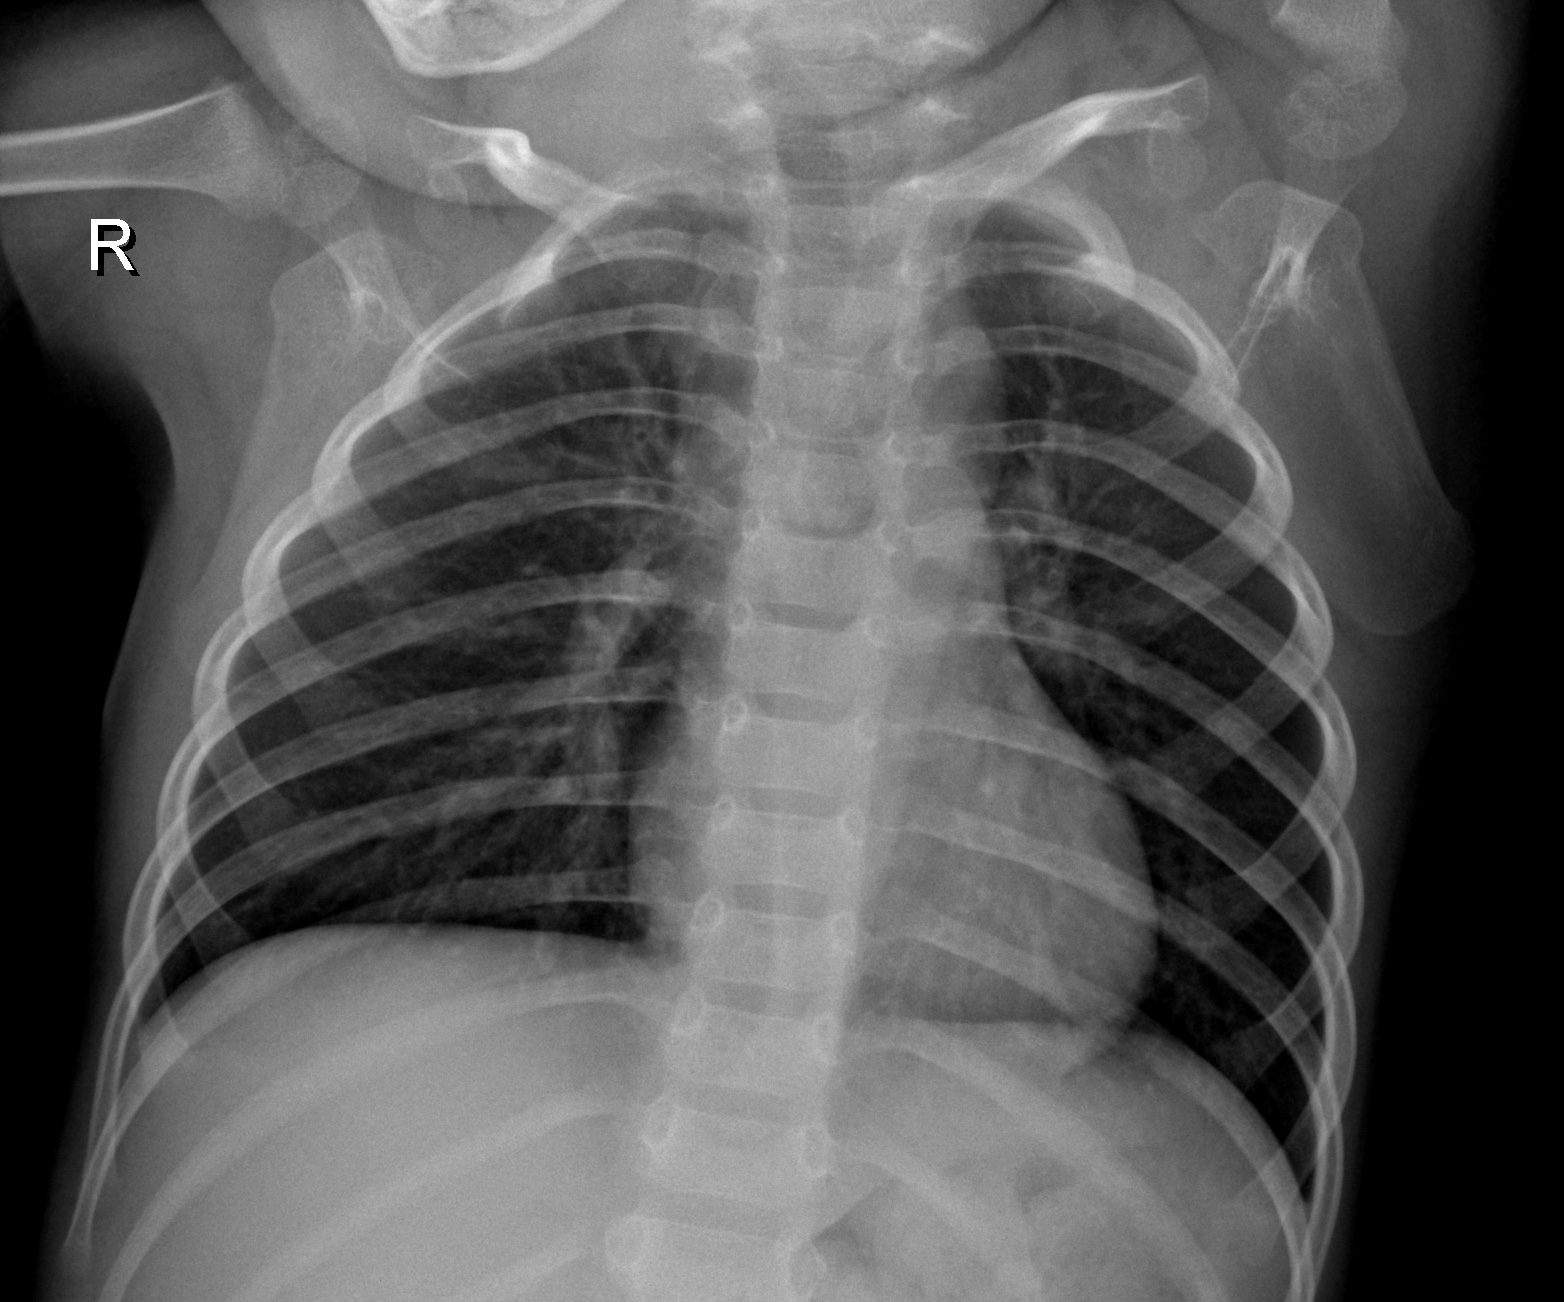

In [60]:
a='C:/Users/bhavye/Downloads/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'
predict = pneumoniaPrediction([prepare(a)])
print(predict,"\n")
IPython.display.Image(filename=a,width=250,height=250)


1/1 [==============================] - 0s 36ms/step
Pneumonia 



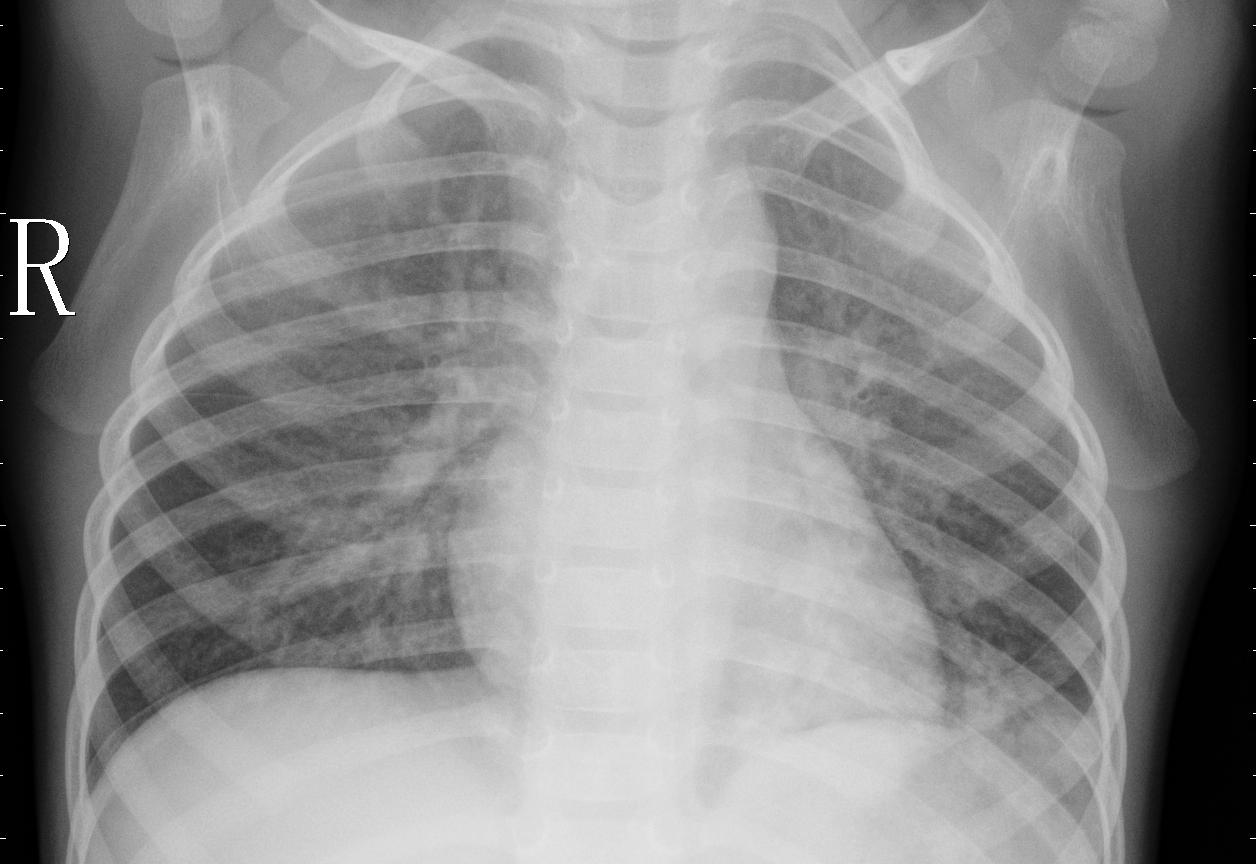

In [55]:
a='C:/Users/bhavye/Downloads/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'
predict = pneumoniaPrediction([prepare(a)])
print(predict,"\n")
IPython.display.Image(filename=a,width=250,height=350)